# Tree Skelteon Segmentation using treditional ML methods

- Import images
- Remove background using otzu method
- Feature extraction methods
- Training of 3 differnt ML classifiers 
- Grid serach for the best of the 3 models
- Accuracy check 
- Image segmentation 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import librearies 

In [2]:
from skimage import filters
import numpy as np
import cv2
import pandas as pd
from scipy import ndimage as nd
import pickle
from skimage.filters import roberts, sobel, scharr, prewitt
from matplotlib import pyplot as plt
import os
import sklearn
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

### Otsu threshold method for background removal 
https://chris-s-park.medium.com/image-background-removal-using-opencv-part-1-da3695ac66b6

In [3]:


def remove_background(img,num):    
    # if num ==1:
    #   lower_color_bounds = np.array([50, 49, 63]) # the order of the colors is blue, green, red
    #   upper_color_bounds = np.array([137,148, 183])
    #   mask = cv2.inRange(img, lower_color_bounds, upper_color_bounds)
    #   img = cv2.bitwise_and(img, img, mask = mask)
    img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # Display traning image and testing image
    # fx, plots = plt.subplots(1, 2, figsize=(10,10))
    # plots[0].set_title("RGB_image")
    # plots[0].imshow(cv2.cvtColor(input_img,cv2.COLOR_BGR2RGB))
    # plots[1].set_title("grey_image")
    # plots[1].imshow(img)
    return img

## Removes non informative featuers 
Features that has only one value in then (most of them contain only 0's) are not informative there for we will remove them.


In [6]:

def cleanData(data):
  for i in data.columns:# go over the dataSets coulmns
    (unique, counts) = np.unique(data[i], return_counts=True)
    frequencies = np.asarray((unique, counts)).T# count unique vaulues
    #print ("class ",i," has ", len(unique))
    if len(unique)== 2:# if there are only two unique options
      zero = counts[0]
      one = counts[1]
      proportion = one/(zero+one)
      #print("one's proportion for",i, " is: ",proportion)# and the proportion of base class (0) is greater that 99% 
      if proportion<0.05 or proportion>0.95: # one percent
        data = data.drop([i], axis=1)# we assume the feature is not giving enough information --> will remove this feature
    if len(unique)==1:
        data=data.drop([i], axis=1)# we assume the feature is not giving enough information --> will remove this feature
        #print ("class ",i," has been removed")

        #print(data.size)
  return data
  
def calc_weights_class():
  # (unique, counts) = np.unique(dataset["Label_Value"], return_counts=True)
  classes = [0,1]
  cw = compute_class_weight('balanced', classes, Y) # If ‘balanced’, class weights will be given by n_samples / (n_classes * np.bincount(y))
  return cw


def remove_less_significant_features(X,feature_importance, names):
    sl = 0.005
    columns_dropped = np.array([])
    for i in range(len(feature_importance.values)): 
        val=feature_importance[0][i]
        col = names[0][i]
        if val < sl and val>0 or val>sl and val<0 :
            X.drop(col, axis='columns', inplace=True)
            columns_dropped = np.append(columns_dropped, [col])
    print("col droped: ",columns_dropped )
    return X


def remove_by_featureImp(model,X,Y):
    feature_importance = model.feature_importances_
    feat_imp=pd.DataFrame(feature_importance) 
    names=pd.DataFrame(X.columns)
    X_new=remove_less_significant_features(X,feat_imp,names)
    dataset = pd.concat([X_new, Y], axis=1)
    return dataset

### plot feature importance

In [ ]:
def plot_feature_importance(importance,names,model_type):
  feature_importance = np.array(importance)
  feature_names = np.array(names)
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

  #Define size of bar plot
  plt.figure(figsize=(10,8))
  #Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
  #Add chart labels
  plt.title(model_type + 'FEATURE IMPORTANCE')
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')


### Feature extraction function 


In [16]:
def feature_extraction(temp, img,src):
    df = pd.DataFrame()

    #Save original image pixels into a data frame. This is our Feature #1.
    img2 = img.reshape(-1)
    df = pd.DataFrame()
    df['Original Image'] = img2
   
    red_channel = src[:,:,2]
    green_channel = src[:,:,1]
    blue_channel = src[:,:,0]
    df['red*green']=(red_channel.reshape(-1))*green_channel.reshape(-1)
    df['blue*green']=(blue_channel.reshape(-1))*green_channel.reshape(-1)
    df['red*blue']=(red_channel.reshape(-1))*blue_channel.reshape(-1)

    df['red'] = red_channel.reshape(-1)
    df['green'] = green_channel.reshape(-1)
    df['blue'] = blue_channel.reshape(-1)
   
    # now we create filters in order to teach the ml model
    #Add pixel values to the data frame
    pixel_values = img.reshape(-1)
    df['Pixel_Value'] = pixel_values   #Pixel value itself as a feature
    # df['Image_Name'] = image   #Capture image name as we read multiple images
    
    # Generate Gabor features # https://en.wikipedia.org/wiki/Gabor_filter#:~:text=In%20image%20processing%2C%20a%20Gabor,point%20or%20region%20of%20analysis.
    num = 1  # To count numbers up in order to give Gabor features a lable in the data frame
    kernels = []
    theta = 0
    for theta in range(2):   # Define number of thetas
        theta += theta / 4 
        for sigma in range(10, 45, 5):  # Sigma with 1 and 3
            for lamda in np.arange(0, np.pi, np.pi / 4):  # Range of wavelengths
                for gamma in (0.05, 0.45, 0.05):   # Gamma values of 0.05 and 0.5
                    gabor_label = 'Gabor' + str(num)  #Label Gabor columns as Gabor1, Gabor2, etc.
                    print(gabor_label)
                    ksize=9
                    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
                    kernels.append(kernel)
                    #Now filter the image and add values to a new column 
                    fimg = cv2.filter2D(img2, cv2.CV_8UC3, kernel)
                    filtered_img = fimg.reshape(-1)
                    df[gabor_label] = filtered_img  #Labels columns as Gabor1, Gabor2, etc.
                    # print(gabor_label, ': theta=', theta, ': sigma=', sigma, ': lamda=', lamda, ': gamma=', gamma)
                    temp['gabor_label'].append(gabor_label)
                    temp['theta'].append(theta)
                    temp['sigma'].append(sigma)
                    temp['lamda'].append(lamda)
                    temp['gamma'].append(gamma)
                    num += 1  #Increment for gabor column label
    return temp


    # CANNY EDGE
    edges = cv2.Canny(img, 100,200)   #Image, min and max values
    edges1 = edges.reshape(-1)
    df['Canny Edge'] = edges1 #Add column to original dataframe

    # ROBERTS EDGE
    edge_roberts = roberts(img)
    edge_roberts1 = edge_roberts.reshape(-1)
    df['Roberts'] = edge_roberts1

    # SOBEL
    edge_sobel = sobel(img)
    edge_sobel1 = edge_sobel.reshape(-1)
    df['Sobel'] = edge_sobel1

    # SCHARR
    edge_scharr = scharr(img)
    edge_scharr1 = edge_scharr.reshape(-1)
    df['Scharr'] = edge_scharr1

    # PREWITT
    edge_prewitt = prewitt(img)
    edge_prewitt1 = edge_prewitt.reshape(-1)
    df['Prewitt'] = edge_prewitt1

    # GAUSSIAN with sigma = 3
    from scipy import ndimage as nd
    gaussian_img = nd.gaussian_filter(img, sigma=3)
    gaussian_img1 = gaussian_img.reshape(-1)
    df['Gaussian s3'] = gaussian_img1

    # GAUSSIAN with sigma = 7
    gaussian_img2 = nd.gaussian_filter(img, sigma=7)
    gaussian_img3 = gaussian_img2.reshape(-1)
    df['Gaussian s7'] = gaussian_img3

    # MEDIAN 
    median_img = nd.median_filter(img, size=3)
    median_img1 = median_img.reshape(-1)
    df['Median s3'] = median_img1
    
    
    # VARIANCE 
    variance_img = nd.generic_filter(img, np.var, size=3)
    variance_img1 = variance_img.reshape(-1)
    df['Variance s3'] = variance_img1 

    return df

In [ ]:
import math
def preformance_measures(groundtruth_list, predicted_list):
    TN, FP, FN, TP = sklearn.metrics.confusion_matrix(groundtruth_list, predicted_list).ravel()
    print("Semantic segmentation measures")
    print("Pixel accuracy = ",sklearn.metrics.accuracy_score(groundtruth_list, predicted_list))
    print("IoU = ",TP/(TP+FP+FN))

    print("Imbalanced dataset measures")
    print("MCC = ",sklearn.metrics.matthews_corrcoef(groundtruth_list, predicted_list))
    print("F1 score = ",sklearn.metrics.f1_score(groundtruth_list, predicted_list,average='weighted'))
    print("Weighted TPR − TNR = ",(0.05*(TP/(TP+FN))+0.95*(TN/(TN+FP))))
    print("Geometric mean = ", math.sqrt((TP/(TP+FN))*(TN/(TN+FP))))
    print("TPR = ", TP/(TP+FN)) 
    print("FPR = ", FN/(TP+FN)) 
    print("recall = ",sklearn.metrics.recall_score(groundtruth_list, predicted_list))
    FPR, TPR, _ = sklearn.metrics.roc_curve(groundtruth_list, predicted_list)
    print("AUC of ROC Curve = ", sklearn.metrics.roc_auc_score(groundtruth_list, predicted_list,average='weighted'))
    plt.plot(FPR, TPR)
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()     
          
    cf_matrix = confusion_matrix(y_true = groundtruth_list,y_pred = predicted_list)
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

# create dataset

## Features dataset

In [21]:

image_dataset = pd.DataFrame()  #Dataframe to capture image features
temp = {'gabor_label': [], 'theta' : [], 'sigma': [],'lamda': [], 'gamma': []}
img_path = r'/content/drive/MyDrive/Colab Notebooks/tesis/all_images/'
x = 0
for image in sorted(os.listdir(img_path)):
  if x > 1:
    break
  else:
    if image.endswith('.json'):
      continue
    else:  
      print(image)
      
      df = pd.DataFrame() #Reset dataframe to blank after each loop.
      input_img = cv2.imread(img_path + image)  #Read images
      input_img = cv2.resize(input_img, (244,244))
      img = remove_background(input_img,1)
      temp = feature_extraction(temp, img, input_img)
      x += 1

temp2 = pd.DataFrame.from_dict(temp)
temp2 = temp2.drop_duplicates()
temp2.to_csv('/content/drive/MyDrive/Colab Notebooks/tesis/file_name.csv')


    # image_dataset = image_dataset.append(feature_extraction(img, input_img))
#### for random forest only
image_dataset = pd.DataFrame(image_dataset.drop(labels = ['red*green', 'blue*green' ,'red*blue' ,'Gabor4' ,'Gabor5', 'Gabor6' ,'Gabor16',
 'Gabor17','Gabor18' ,'Gabor28' ,'Gabor29' ,'Gabor30', 'Gabor40' ,'Gabor41',
 'Gabor42', 'Gabor52', 'Gabor53' ,'Gabor54' ,'Gabor64' ,'Gabor65', 'Gabor66',
 'Gabor76' ,'Gabor77' ,'Gabor78' ,'Gabor91' ,'Gabor92' ,'Gabor93' ,'Gabor94',
 'Gabor95' ,'Gabor96', 'Gabor103' ,'Gabor104' ,'Gabor105' ,'Gabor106',
 'Gabor107', 'Gabor108', 'Gabor112' ,'Gabor114' ,'Gabor115' ,'Gabor116',
 'Gabor117' ,'Gabor118' ,'Gabor119', 'Gabor120' ,'Gabor124', 'Gabor126',
 'Gabor127' ,'Gabor128','Gabor129' ,'Gabor130' ,'Gabor131' ,'Gabor132',
 'Gabor136' ,'Gabor137', 'Gabor138' ,'Gabor139' ,'Gabor140','Gabor141',
 'Gabor142' ,'Gabor143' ,'Gabor144' ,'Gabor148' ,'Gabor149' ,'Gabor150',
 'Gabor151' ,'Gabor152' ,'Gabor153' ,'Gabor154' ,'Gabor155' ,'Gabor156',
 'Gabor160' ,'Gabor162', 'Gabor163' ,'Gabor164' ,'Gabor165' ,'Gabor166',
 'Gabor167' ,'Gabor168'], axis=1))


## for SVM only
# image_dataset = pd.DataFrame(image_dataset.drop(labels = ['Gabor16', 'Gabor17', 'Gabor18', 'Gabor28','Gabor29', 'Gabor30' ,'Gabor40' ,'Gabor41' ,'Gabor42', 'Gabor52', 'Gabor53' ,'Gabor54', 'Gabor64', 'Gabor65','Gabor66', 'Gabor76', 'Gabor77', 'Gabor78', 'Gabor104' ,'Gabor136', 'Gabor138', 'Gabor148' ,'Gabor150'], axis=1)) 

image_dataset=cleanData(image_dataset)



29.9_10_1.png
Gabor1
Gabor2
Gabor3
Gabor4
Gabor5
Gabor6
Gabor7
Gabor8
Gabor9
Gabor10
Gabor11
Gabor12
Gabor13
Gabor14
Gabor15
Gabor16
Gabor17
Gabor18
Gabor19
Gabor20
Gabor21
Gabor22
Gabor23
Gabor24
Gabor25
Gabor26
Gabor27
Gabor28
Gabor29
Gabor30
Gabor31
Gabor32
Gabor33
Gabor34
Gabor35
Gabor36
Gabor37
Gabor38
Gabor39
Gabor40
Gabor41
Gabor42
Gabor43
Gabor44
Gabor45
Gabor46
Gabor47
Gabor48
Gabor49
Gabor50
Gabor51
Gabor52
Gabor53
Gabor54
Gabor55
Gabor56
Gabor57
Gabor58
Gabor59
Gabor60
Gabor61
Gabor62
Gabor63
Gabor64
Gabor65
Gabor66
Gabor67
Gabor68
Gabor69
Gabor70
Gabor71
Gabor72
Gabor73
Gabor74
Gabor75
Gabor76
Gabor77
Gabor78
Gabor79
Gabor80
Gabor81
Gabor82
Gabor83
Gabor84
Gabor85
Gabor86
Gabor87
Gabor88
Gabor89
Gabor90
Gabor91
Gabor92
Gabor93
Gabor94
Gabor95


<ipython-input-16-df04422d6b82>:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[gabor_label] = filtered_img  #Labels columns as Gabor1, Gabor2, etc.


Gabor96
Gabor97
Gabor98
Gabor99
Gabor100
Gabor101
Gabor102
Gabor103
Gabor104
Gabor105
Gabor106
Gabor107
Gabor108
Gabor109
Gabor110
Gabor111
Gabor112
Gabor113
Gabor114
Gabor115
Gabor116
Gabor117
Gabor118
Gabor119
Gabor120
Gabor121
Gabor122
Gabor123
Gabor124
Gabor125
Gabor126
Gabor127
Gabor128
Gabor129
Gabor130
Gabor131
Gabor132
Gabor133
Gabor134
Gabor135
Gabor136
Gabor137
Gabor138
Gabor139
Gabor140
Gabor141
Gabor142
Gabor143
Gabor144
Gabor145
Gabor146
Gabor147
Gabor148
Gabor149
Gabor150
Gabor151
Gabor152
Gabor153
Gabor154
Gabor155
Gabor156
Gabor157
Gabor158
Gabor159
Gabor160
Gabor161
Gabor162
Gabor163
Gabor164
Gabor165
Gabor166
Gabor167
Gabor168
29.9_10_10.png
Gabor1
Gabor2
Gabor3
Gabor4
Gabor5
Gabor6
Gabor7
Gabor8
Gabor9
Gabor10
Gabor11
Gabor12
Gabor13
Gabor14
Gabor15
Gabor16
Gabor17
Gabor18
Gabor19
Gabor20
Gabor21
Gabor22
Gabor23
Gabor24
Gabor25
Gabor26
Gabor27
Gabor28
Gabor29
Gabor30
Gabor31
Gabor32
Gabor33
Gabor34
Gabor35
Gabor36
Gabor37
Gabor38
Gabor39
Gabor40
Gabor41
Gabor42
Gabor

KeyError: ignored

## Labels DataSet 

In [ ]:
mask_dataset = pd.DataFrame()  #Create dataframe to capture mask info.

mask_path = r'/content/drive/MyDrive/Colab Notebooks/segmentation/Branch/ground_truth/skeleton/'  
mask_list = sorted(os.listdir(mask_path))  
for mask in mask_list:  #iterate through each file to perform some action
    print(mask)
    
    df2 = pd.DataFrame()  #Temporary dataframe to capture info for each mask in the loop
    input_mask = cv2.imread(mask_path + mask)
    input_mask = cv2.resize(input_mask, (244,244), interpolation =cv2.INTER_NEAREST)
    #Check if the input mask is RGB or grey and convert to grey if RGB
    label = cv2.cvtColor(input_mask,cv2.COLOR_BGR2GRAY)
    #Add pixel values to the data frame
    df2['Label_Value'] = label.reshape(-1)
    # df2['Mask_Name'] = mask
    
    mask_dataset = mask_dataset.append(df2)  #Update mask dataframe with all the info from each mask


10_37.png
10_39.png
10_40.png
10_41.png
13_11.png
13_14.png
13_30.png
13_33.png
13_37.png
16_2.png
16_23.png
16_28.png
16_30.png
16_33.png


## Pickle upload data command (only on the first run of the day)

In [ ]:

dataset = pd.concat([image_dataset, mask_dataset], axis=1)    #Concatenate both image and mask datasets

import pickle
#Save the trained model as pickle string to disk for future use

filename = "data"
pickle.dump(dataset, open(filename, 'wb'))

print("done")    
##If we do not want to include pixels with value 0 
##e.g. Sometimes unlabeled pixels may be given a value 0.
# dataset = dataset[dataset.Label_Value != 0]

done


# Train and Test split + download data from pickle

test will be 20% of total data

In [ ]:

dataset=pickle.load(open("data", 'rb'))
dataset=pd.DataFrame(dataset)
dataset=dataset.drop_duplicates(subset=None, keep='first', inplace=False)
#Drop columns that are not relevant for training (non-features)
X = pd.DataFrame(dataset.drop(labels = ["Label_Value"], axis=1)) 

 
scale = sklearn.preprocessing.StandardScaler()
X = pd.DataFrame(scale.fit_transform(X))

#Assign label values to Y (our prediction)
Y = pd.DataFrame(dataset["Label_Value"].values /255)

#Encode Y values to 0, 1, 2, 3, .... (NOt necessary but makes it easy to use other tools like ROC plots)
from sklearn.preprocessing import LabelEncoder
Y = LabelEncoder().fit_transform(Y)


##Split data into train and test to verify accuracy after fitting the model. 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

X_train.shape

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(660956, 23)

# Descriptive statistics
https://neptune.ai/blog/data-exploration-for-image-segmentation-and-object-detection


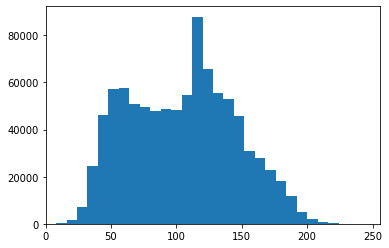

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.data as data
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color

def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 14))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

# image_show(input_img)

fig, ax = plt.subplots(1, 1)
ax.hist(input_img.ravel(), bins=32, range=[0, 256])
ax.set_xlim(0, 256);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


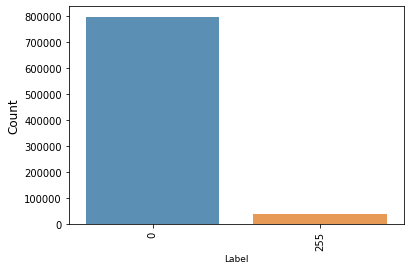

In [ ]:

value_counts = dataset['Label_Value'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(value_counts.index, value_counts.values, alpha=0.8)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Label', fontsize=9)
plt.xticks(rotation=90)
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f87742f2290>,
      dtype=object)

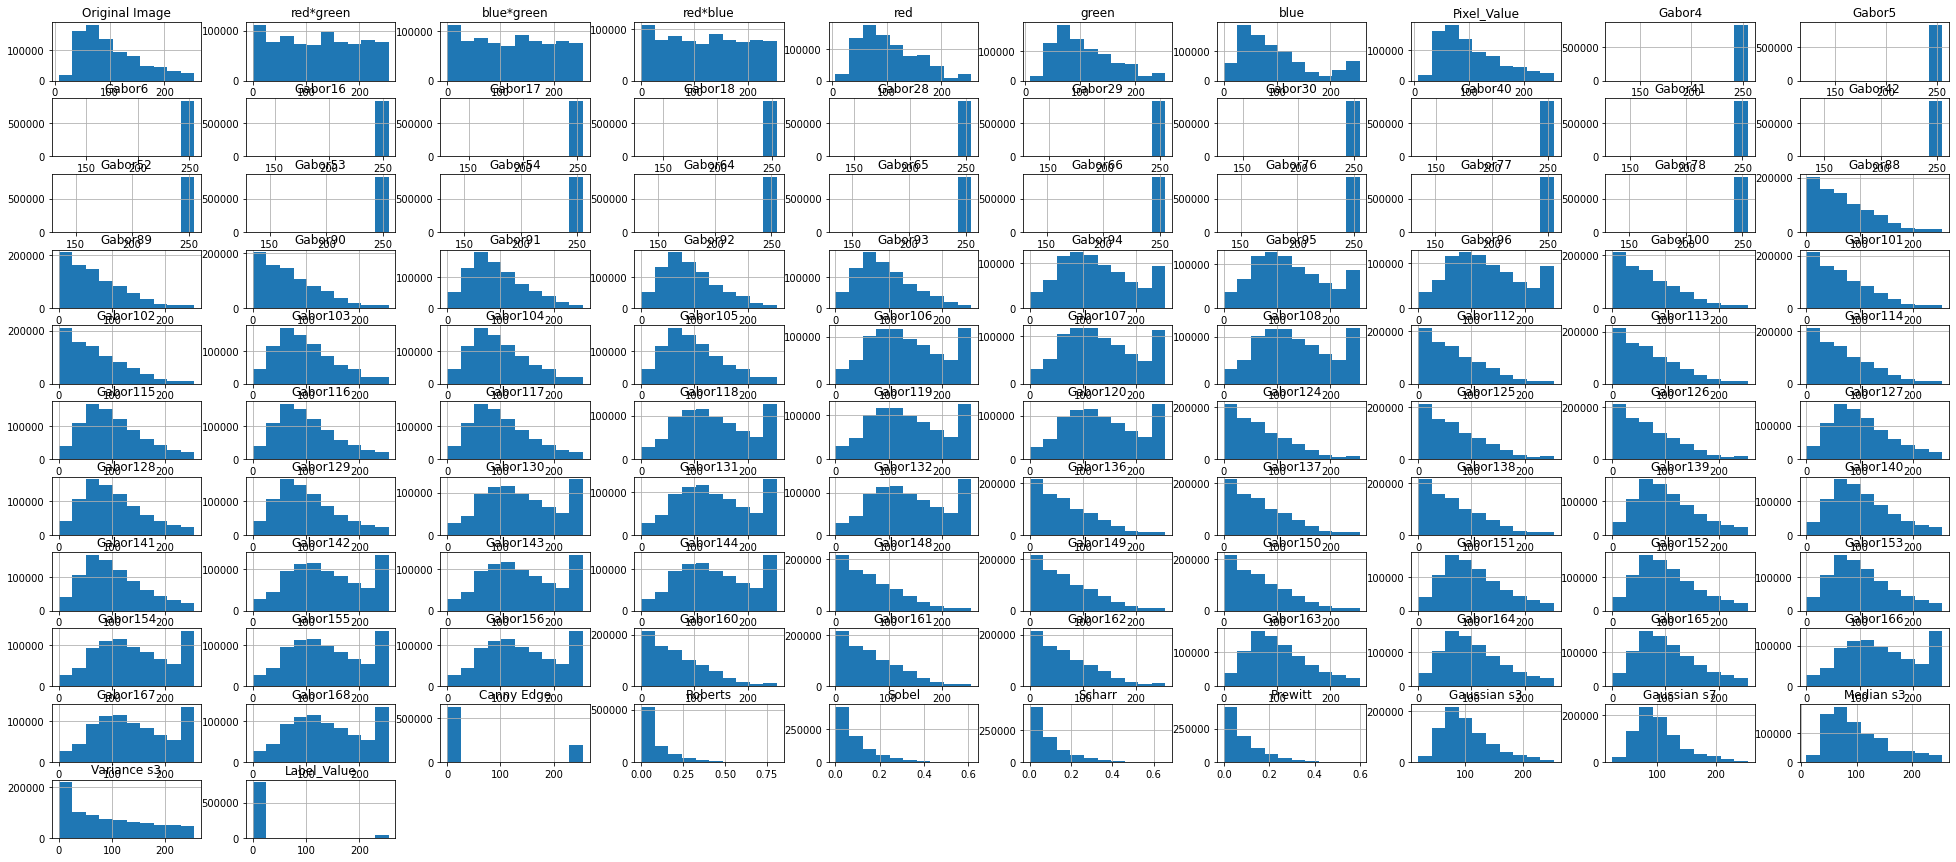

In [ ]:
attributes = dataset.select_dtypes(include=['number'])
attributes.hist(figsize=(34,15))

In [ ]:
import seaborn as sns
sns.set_style("white")
for i in dataset.columns:
  x1 = dataset.loc[dataset["Label_Value"] == 0, i]
  x2 = dataset.loc[dataset["Label_Value"] == 255, i]

  # Plot
  kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

  plt.figure(figsize=(10,7), dpi= 80)
  sns.distplot(x1, color="dodgerblue", label="0", **kwargs)
  sns.distplot(x2, color="orange", label="1", **kwargs)
  plt.legend();

# Modeling

### Random Forest
    

[ 0.52359553 11.09522722]
Semantic segmentation measures
Pixel accuracy =  0.8149831456254274
IoU =  0.1478900719103629
Imbalanced dataset measures
MCC =  0.27346692685898716
F1 score =  0.8655562962024537
Weighted TPR − TNR =  0.8144569886813395
Geometric mean =  0.7633522153498471
TPR =  0.7106884543262791
FPR =  0.28931154567372086
AUC of ROC Curve =  0.7653034724078898


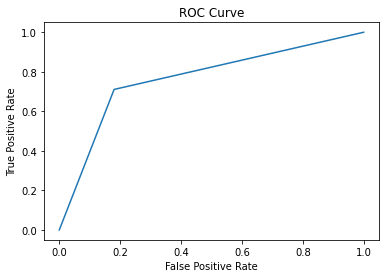

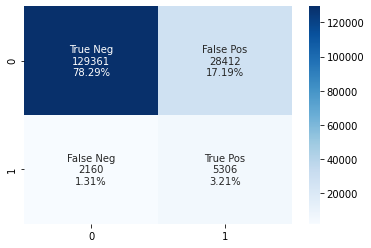

In [ ]:
from sklearn.ensemble import RandomForestClassifier
cw = calc_weights_class() # tree class's weights 
print(cw)
model = RandomForestClassifier(n_estimators = 100,criterion='gini',max_depth=8, random_state = 42,class_weight={0: cw[0], 1: cw[1]},verbose=2)
model=model.fit(X_train,y_train)
predicted_list=model.predict(X_test)
preformance_measures(y_test, predicted_list)

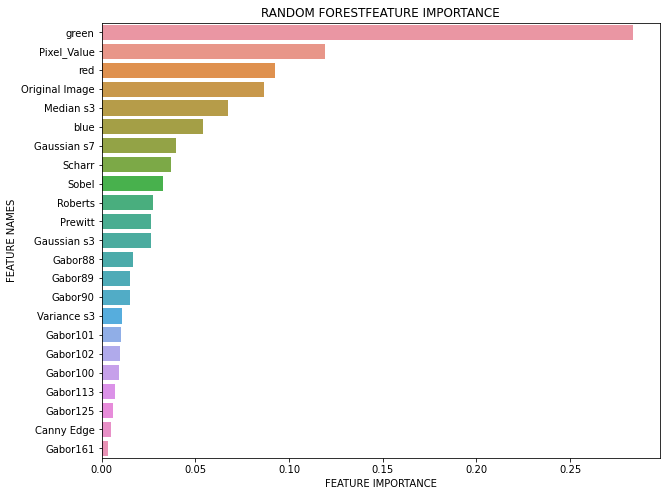

In [ ]:
plot_feature_importance(model.feature_importances_,X.columns,'RANDOM FOREST')


In [ ]:
X = pd.DataFrame(dataset.drop(labels = ["Label_Value"], axis=1)) 
Y_new=pd.DataFrame(dataset["Label_Value"].values /255)
new_data=remove_by_featureImp(model,X,Y_new)

# filename = "data_rf"
# pickle.dump(dataset, open(filename, 'wb'))


In [ ]:
#for SVM
X_new = pd.DataFrame(dataset.drop(labels = ['Gabor16', 'Gabor17', 'Gabor18', 'Gabor28','Gabor29', 'Gabor30' ,'Gabor40','Label_Value' ,'Gabor41' ,'Gabor42', 'Gabor52', 'Gabor53' ,'Gabor54', 'Gabor64', 'Gabor65','Gabor66', 'Gabor76', 'Gabor77', 'Gabor78', 'Gabor104' ,'Gabor136', 'Gabor138', 'Gabor148' ,'Gabor150'], axis=1)) 
X_train, X_test, y_train, y_test = train_test_split(X_new,Y, test_size=0.2, random_state=20)


In [ ]:
amir=pd.DataFrame(D)
amir.to_csv(r"C:\Users\amirc\Desktop\BGU\CleanData.csv")

In [ ]:
predicted_list=best_grid.predict(X_test)
preformance_measures(y_test, predicted_list)

## RF grid search
this will take a lot of time

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] criterion=gini, max_depth=8, n_estimators=200 ...................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=gini, max_depth=8, n_estimators=200, score=0.852, total= 4.0min
[CV] criterion=gini, max_depth=8, n_estimators=200 ...................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.0min remaining:    0.0s


[CV]  criterion=gini, max_depth=8, n_estimators=200, score=0.856, total= 4.6min
[CV] criterion=gini, max_depth=8, n_estimators=200 ...................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  8.6min remaining:    0.0s


[CV]  criterion=gini, max_depth=8, n_estimators=200, score=0.850, total= 4.6min
[CV] criterion=gini, max_depth=8, n_estimators=200 ...................
[CV]  criterion=gini, max_depth=8, n_estimators=200, score=0.852, total= 4.5min
[CV] criterion=gini, max_depth=8, n_estimators=200 ...................
[CV]  criterion=gini, max_depth=8, n_estimators=200, score=0.853, total= 4.6min
[CV] criterion=gini, max_depth=8, n_estimators=300 ...................
[CV]  criterion=gini, max_depth=8, n_estimators=300, score=0.853, total= 6.7min
[CV] criterion=gini, max_depth=8, n_estimators=300 ...................
[CV]  criterion=gini, max_depth=8, n_estimators=300, score=0.856, total= 6.9min
[CV] criterion=gini, max_depth=8, n_estimators=300 ...................
[CV]  criterion=gini, max_depth=8, n_estimators=300, score=0.850, total= 6.9min
[CV] criterion=gini, max_depth=8, n_estimators=300 ...................
[CV]  criterion=gini, max_depth=8, n_estimators=300, score=0.853, total= 7.0min
[CV] criterion

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 290.2min finished


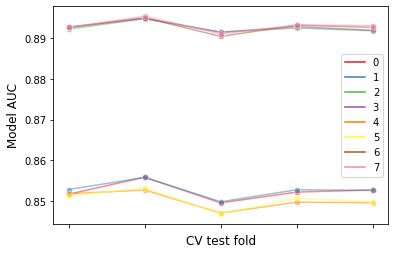

Correlation of models:
           0         1         2  ...         5         6         7
0  1.000000  0.974938  0.910141  ...  0.892155  0.965647  0.991512
1  0.974938  1.000000  0.911141  ...  0.969466  0.989654  0.986077
2  0.910141  0.911141  1.000000  ...  0.838005  0.893498  0.920747
3  0.903006  0.936364  0.987444  ...  0.900048  0.924103  0.928391
4  0.818051  0.917363  0.781816  ...  0.970221  0.880021  0.838648
5  0.892155  0.969466  0.838005  ...  1.000000  0.962414  0.924203
6  0.965647  0.989654  0.893498  ...  0.962414  1.000000  0.989172
7  0.991512  0.986077  0.920747  ...  0.924203  0.989172  1.000000

[8 rows x 8 columns]
Semantic segmentation measures
Pixel accuracy =  0.8996120770520276
IoU =  0.23352740042509934
Imbalanced dataset measures
MCC =  0.380260959413879
F1 score =  0.9197870444412218
Weighted TPR − TNR =  0.8984886942886094
Geometric mean =  0.7849282640094338
TPR =  0.6769354406643451
FPR =  0.323064559335655
recall =  0.6769354406643451
AUC of ROC Cur

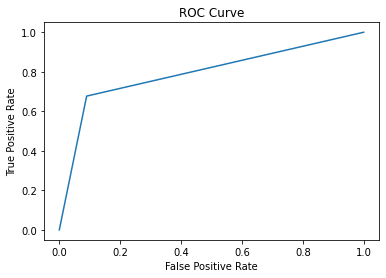

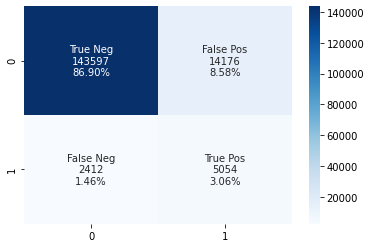

In [ ]:
import math

# param_grid = { 
#     'n_estimators': [200, 500],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : [4,5,6,7,8],
#     'criterion' :['gini', 'entropy']
# }

# Create the parameter grid based on the results of random search 

cw = calc_weights_class() # tree class's weights 

param_grid = { 
    'n_estimators': [200,300],
    'max_depth' : [8,14],
    'criterion' :['gini', 'entropy']
}
# Create a based model
rf=RandomForestClassifier(random_state=42,class_weight={0: cw[0], 1: cw[1]})
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf,verbose=3, param_grid = param_grid,scoring='roc_auc_ovo_weighted',cv=5)# cv=10 for cross validation tunning
# fit it 
grid_search.fit(X_train, y_train)
# best parms
grid_search.best_params_
# best estimator 
best_grid = grid_search.best_estimator_
# grid_accuracy = evaluate(best_grid, X_test, y_test)
# print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

# evaluation#############################################################################################################################
results_df = pd.DataFrame(grid_search.cv_results_)

# create df of model scores ordered by perfomance
model_scores = results_df.filter(regex=r'split\d*_test_score')

# plot 30 examples of dependency between cv fold and AUC scores
fig, ax = plt.subplots()
sns.lineplot(
    data=model_scores.transpose().iloc[:30],
    dashes=False, palette='Set1', marker='o', alpha=.5, ax=ax
)
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Model AUC", size=12)
ax.tick_params(bottom=True, labelbottom=False)
plt.show()

# print correlation of AUC scores across folds
print(f"Correlation of models:\n {model_scores.transpose().corr()}")


predicted_list=best_grid.predict(X_test)
preformance_measures(y_test, predicted_list)

## SVM


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] C=10, gamma=scale ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] ................... C=10, gamma=scale, score=0.434, total= 3.3min
[CV] C=10, gamma=scale ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] ................... C=10, gamma=scale, score=0.505, total= 3.4min
[CV] C=10, gamma=scale ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.7min remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] ................... C=10, gamma=scale, score=0.202, total= 3.4min
[CV] C=10, gamma=scale ...............................................


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] ................... C=10, gamma=scale, score=0.695, total= 3.4min
[CV] C=10, gamma=scale ...............................................


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] ................... C=10, gamma=scale, score=0.171, total= 3.3min
[CV] C=10, gamma=auto ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] .................... C=10, gamma=auto, score=0.434, total= 3.3min
[CV] C=10, gamma=auto ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] .................... C=10, gamma=auto, score=0.505, total= 3.4min
[CV] C=10, gamma=auto ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] .................... C=10, gamma=auto, score=0.202, total= 3.4min
[CV] C=10, gamma=auto ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] .................... C=10, gamma=auto, score=0.695, total= 3.4min
[CV] C=10, gamma=auto ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] .................... C=10, gamma=auto, score=0.171, total= 3.3min
[CV] C=15, gamma=scale ...............................................


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] ................... C=15, gamma=scale, score=0.288, total= 3.3min
[CV] C=15, gamma=scale ...............................................


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] ................... C=15, gamma=scale, score=0.630, total= 3.3min
[CV] C=15, gamma=scale ...............................................


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] ................... C=15, gamma=scale, score=0.196, total= 3.4min
[CV] C=15, gamma=scale ...............................................


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] ................... C=15, gamma=scale, score=0.612, total= 3.4min
[CV] C=15, gamma=scale ...............................................


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] ................... C=15, gamma=scale, score=0.243, total= 3.3min
[CV] C=15, gamma=auto ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] .................... C=15, gamma=auto, score=0.288, total= 3.3min
[CV] C=15, gamma=auto ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] .................... C=15, gamma=auto, score=0.630, total= 3.3min
[CV] C=15, gamma=auto ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] .................... C=15, gamma=auto, score=0.196, total= 3.4min
[CV] C=15, gamma=auto ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] .................... C=15, gamma=auto, score=0.612, total= 3.4min
[CV] C=15, gamma=auto ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] .................... C=15, gamma=auto, score=0.243, total= 3.3min
[CV] C=20, gamma=scale ...............................................


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] ................... C=20, gamma=scale, score=0.623, total= 3.3min
[CV] C=20, gamma=scale ...............................................


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] ................... C=20, gamma=scale, score=0.727, total= 3.4min
[CV] C=20, gamma=scale ...............................................


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] ................... C=20, gamma=scale, score=0.529, total= 3.3min
[CV] C=20, gamma=scale ...............................................


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] ................... C=20, gamma=scale, score=0.612, total= 3.4min
[CV] C=20, gamma=scale ...............................................


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] ................... C=20, gamma=scale, score=0.664, total= 3.3min
[CV] C=20, gamma=auto ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] .................... C=20, gamma=auto, score=0.623, total= 3.3min
[CV] C=20, gamma=auto ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] .................... C=20, gamma=auto, score=0.727, total= 3.4min
[CV] C=20, gamma=auto ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] .................... C=20, gamma=auto, score=0.529, total= 3.3min
[CV] C=20, gamma=auto ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] .................... C=20, gamma=auto, score=0.612, total= 3.4min
[CV] C=20, gamma=auto ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] .................... C=20, gamma=auto, score=0.664, total= 3.3min
[CV] C=50, gamma=scale ...............................................


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] ................... C=50, gamma=scale, score=0.604, total= 3.3min
[CV] C=50, gamma=scale ...............................................


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] ................... C=50, gamma=scale, score=0.727, total= 3.4min
[CV] C=50, gamma=scale ...............................................


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] ................... C=50, gamma=scale, score=0.613, total= 3.4min
[CV] C=50, gamma=scale ...............................................


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] ................... C=50, gamma=scale, score=0.612, total= 3.3min
[CV] C=50, gamma=scale ...............................................


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] ................... C=50, gamma=scale, score=0.196, total= 3.3min
[CV] C=50, gamma=auto ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] .................... C=50, gamma=auto, score=0.604, total= 3.3min
[CV] C=50, gamma=auto ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] .................... C=50, gamma=auto, score=0.727, total= 3.3min
[CV] C=50, gamma=auto ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] .................... C=50, gamma=auto, score=0.613, total= 3.4min
[CV] C=50, gamma=auto ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] .................... C=50, gamma=auto, score=0.612, total= 3.4min
[CV] C=50, gamma=auto ................................................


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV] .................... C=50, gamma=auto, score=0.196, total= 3.3min


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 133.6min finished
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


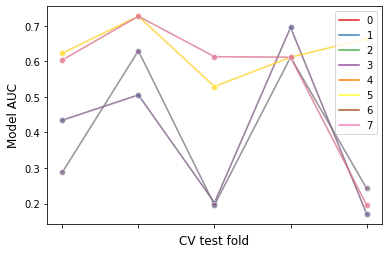

Correlation of models:
           0         1         2  ...         5         6         7
0  1.000000  1.000000  0.867727  ...  0.263341  0.600532  0.600532
1  1.000000  1.000000  0.867727  ...  0.263341  0.600532  0.600532
2  0.867727  0.867727  1.000000  ...  0.565022  0.526389  0.526389
3  0.867727  0.867727  1.000000  ...  0.565022  0.526389  0.526389
4  0.263341  0.263341  0.565022  ...  1.000000 -0.045489 -0.045489
5  0.263341  0.263341  0.565022  ...  1.000000 -0.045489 -0.045489
6  0.600532  0.600532  0.526389  ... -0.045489  1.000000  1.000000
7  0.600532  0.600532  0.526389  ... -0.045489  1.000000  1.000000

[8 rows x 8 columns]
Semantic segmentation measures
Pixel accuracy =  0.6082540335509162
IoU =  0.03303070123043842
Imbalanced dataset measures
MCC =  -0.033570230851924364
F1 score =  0.7214574297659682
Weighted TPR − TNR =  0.6065680044287307
Geometric mean =  0.43131455144069514
TPR =  0.2987170830519919
FPR =  0.7012829169480082
recall =  0.2987170830519919
AUC of R

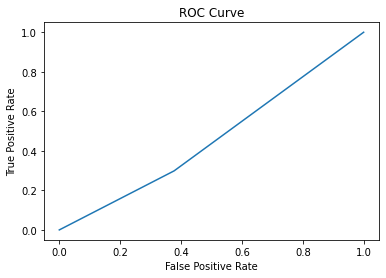

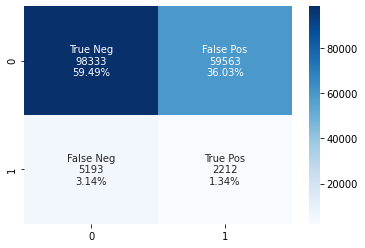

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import svm

# cw = calc_weights_class() # tree class's weights 
param_grid = { 
    'C' : [10,15,20,50],
    'gamma': ['scale', 'auto']
}



grid_search = GridSearchCV(estimator=svm.SVC(kernel='linear',C=10, class_weight='balanced',max_iter=1500), param_grid = param_grid,scoring='accuracy',cv=5,verbose=3)
grid_search.fit(X_train, y_train)

# best parms
grid_search.best_params_
# best estimator 
best_grid = grid_search.best_estimator_

# evaluation
results_df = pd.DataFrame(grid_search.cv_results_)

# create df of model scores ordered by perfomance
model_scores = results_df.filter(regex=r'split\d*_test_score')

# plot 30 examples of dependency between cv fold and AUC scores
fig, ax = plt.subplots()
sns.lineplot(
    data=model_scores.transpose().iloc[:30],
    dashes=False, palette='Set1', marker='o', alpha=.5, ax=ax
)
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Model AUC", size=12)
ax.tick_params(bottom=True, labelbottom=False)
plt.show()

# print correlation of AUC scores across folds
print(f"Correlation of models:\n {model_scores.transpose().corr()}")


predicted_list=best_grid.predict(X_test)
preformance_measures(y_test, predicted_list)

In [ ]:
best_grid

SVC(C=20, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=1500, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

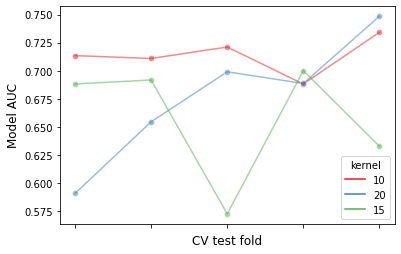

Correlation of models:
 kernel        10        20        15
kernel                              
10      1.000000  0.358960 -0.636706
20      0.358960  1.000000 -0.517687
15     -0.636706 -0.517687  1.000000


In [ ]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values(by=['rank_test_score'])
results_df = (
    results_df
    .set_index(results_df["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)
results_df[
    ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']
]
# create df of model scores ordered by perfomance
model_scores = results_df.filter(regex=r'split\d*_test_score')

# plot 30 examples of dependency between cv fold and AUC scores
fig, ax = plt.subplots()
sns.lineplot(
    data=model_scores.transpose().iloc[:30],
    dashes=False, palette='Set1', marker='o', alpha=.5, ax=ax
)
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Model AUC", size=12)
ax.tick_params(bottom=True, labelbottom=False)
plt.show()

# print correlation of AUC scores across folds
print(f"Correlation of models:\n {model_scores.transpose().corr()}")

# Non linear SVM

In [ ]:
from sklearn import svm
cw = calc_weights_class() # tree c lass's weights 
print(cw)
model = svm.SVC(kernel = 'poly', class_weight={0: cw[0], 1: cw[1]},verbose=2)
model=model.fit(X_train,y_train)


[ 0.52359553 11.09522722]


# Linear SVM

In [ ]:
from sklearn.svm import LinearSVC
from sklearn import svm

cw = calc_weights_class() # tree class's weights 

model = LinearSVC(C=10, class_weight={0: 0.5, 1: 11}, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
          verbose=2)
model=model.fit(X_train,y_train)

[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Semantic segmentation measures
Pixel accuracy =  0.9538365640072864
IoU =  0.025051124744376277
Imbalanced dataset measures
MCC =  0.08617606649263154
F1 score =  0.9344384565362447
Weighted TPR − TNR =  0.9491569885416032
Geometric mean =  0.16184182159517654
TPR =  0.02625234395928208
FPR =  0.9737476560407179
recall =  0.02625234395928208
AUC of ROC Curve =  0.5119916305815564


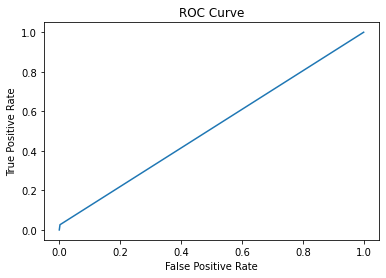

AttributeError: ignored

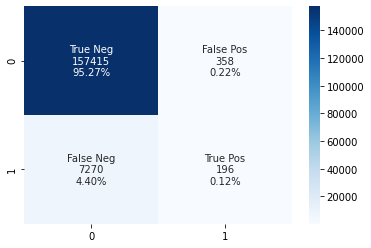

In [ ]:
predicted_list=model.predict(X_test)
preformance_measures(y_test, predicted_list)
plot_feature_importance(model.feature_importances_,X.columns,'LINEAR SVM')


[LibSVM]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


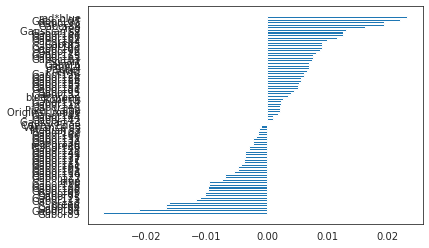

Semantic segmentation measures
Pixel accuracy =  0.4007755502050792
IoU =  0.04451711232009878
Imbalanced dataset measures
MCC =  0.0023193023456193913
F1 score =  0.5331532980241781
Weighted TPR − TNR =  0.4018053445740792
Geometric mean =  0.4900537926468726
TPR =  0.6148414601652011
FPR =  0.3851585398347988
recall =  0.6148414601652011
AUC of ROC Curve =  0.5027171888014528


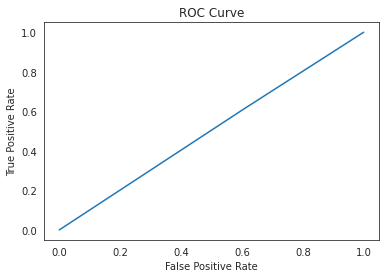

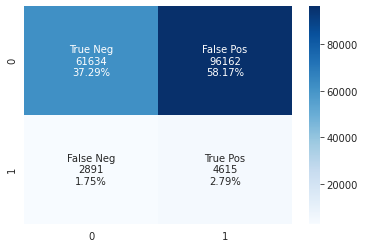

In [ ]:
from sklearn import svm

def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()
features_names=X.columns
svm = svm.SVC(kernel='linear',C=10, class_weight={0: 0.5, 1: 11},max_iter=1500,verbose=3)
svm.fit(X_train,y_train)
f_importances(svm.coef_[0], features_names)
predicted_list=svm.predict(X_test)
preformance_measures(y_test, predicted_list)

In [ ]:
(svm.coef_[0])


array([-0.05346098, -0.14709524, -0.17629085, -0.04198465, -0.13200133,
       -0.62951262,  0.35498434, -0.05346098, -0.16396107,  0.47792568,
       -0.16396107,  0.09918872,  0.09809365,  0.09918872,  0.07326781,
        0.07278669,  0.07326781,  0.00656949,  0.00654142,  0.00656949,
        0.00663119,  0.00666774,  0.00663119,  0.00670182,  0.00668784,
        0.00670182,  0.00675142,  0.00674182,  0.00675142,  1.14435319,
       -1.86435609,  1.14435319, -0.26128267,  0.26689321, -0.26128267,
       -0.16011085,  0.35165196, -0.16011085,  0.26187305, -0.94789493,
        0.26187305, -0.24102683,  0.05539163, -0.24102683, -0.20594648,
        0.32378602, -0.20594648, -0.1626406 , -0.50147664, -0.1626406 ,
       -0.05267268, -0.19789977, -0.05267268, -0.33122562,  0.15301171,
       -0.33122562,  0.11143752, -0.47585031,  0.11143752, -0.06067559,
       -0.07823214, -0.06067559, -0.12779646, -0.14815096, -0.12779646,
        0.06964331, -0.39363376,  0.06964331,  0.23504799,  0.18

In [ ]:
# X = pd.DataFrame(dataset.drop(labels = ["Label_Value"], axis=1)) 

X.columns

Index(['Original Image', 'red*green', 'blue*green', 'red*blue', 'red', 'green',
       'blue', 'Pixel_Value', 'Gabor4', 'Gabor5', 'Gabor6', 'Gabor88',
       'Gabor89', 'Gabor90', 'Gabor91', 'Gabor92', 'Gabor93', 'Gabor94',
       'Gabor95', 'Gabor96', 'Gabor100', 'Gabor101', 'Gabor102', 'Gabor103',
       'Gabor105', 'Gabor106', 'Gabor107', 'Gabor108', 'Gabor112', 'Gabor113',
       'Gabor114', 'Gabor115', 'Gabor116', 'Gabor117', 'Gabor118', 'Gabor119',
       'Gabor120', 'Gabor124', 'Gabor125', 'Gabor126', 'Gabor127', 'Gabor128',
       'Gabor129', 'Gabor130', 'Gabor131', 'Gabor132', 'Gabor137', 'Gabor139',
       'Gabor140', 'Gabor141', 'Gabor142', 'Gabor143', 'Gabor144', 'Gabor149',
       'Gabor151', 'Gabor152', 'Gabor153', 'Gabor154', 'Gabor155', 'Gabor156',
       'Gabor160', 'Gabor161', 'Gabor162', 'Gabor163', 'Gabor164', 'Gabor165',
       'Gabor166', 'Gabor167', 'Gabor168', 'Canny Edge', 'Roberts', 'Sobel',
       'Scharr', 'Prewitt', 'Gaussian s3', 'Gaussian s7', 'Median s3'

In [ ]:
def remove_less_significant_features(X,feature_importance, names):
    sl = 0.1
    columns_dropped = np.array([])
    for i in range(len(feature_importance.values)): 
        val=feature_importance[0][i]
        col = names[0][i]
        if val < sl and val>0 or val>sl and val<0 :
            X.drop(col, axis='columns', inplace=True)
            columns_dropped = np.append(columns_dropped, [col])
    print("col droped: ",columns_dropped )
    return X

remove_less_significant_features(X,pd.DataFrame(svm.coef_[0]),pd.DataFrame(X.columns))

col droped:  ['Gabor16' 'Gabor17' 'Gabor18' 'Gabor28' 'Gabor29' 'Gabor30' 'Gabor40'
 'Gabor41' 'Gabor42' 'Gabor52' 'Gabor53' 'Gabor54' 'Gabor64' 'Gabor65'
 'Gabor66' 'Gabor76' 'Gabor77' 'Gabor78' 'Gabor104' 'Gabor136' 'Gabor138'
 'Gabor148' 'Gabor150']


,Original Image,red*green,blue*green,red*blue,red,green,blue,Pixel_Value,Gabor4,Gabor5,Gabor6,Gabor88,Gabor89,Gabor90,Gabor91,Gabor92,Gabor93,Gabor94,Gabor95,Gabor96,Gabor100,Gabor101,Gabor102,Gabor103,Gabor105,Gabor106,Gabor107,Gabor108,Gabor112,Gabor113,Gabor114,Gabor115,Gabor116,Gabor117,Gabor118,Gabor119,Gabor120,Gabor124,Gabor125,Gabor126,Gabor127,Gabor128,Gabor129,Gabor130,Gabor131,Gabor132,Gabor137,Gabor139,Gabor140,Gabor141,Gabor142,Gabor143,Gabor144,Gabor149,Gabor151,Gabor152,Gabor153,Gabor154,Gabor155,Gabor156,Gabor160,Gabor161,Gabor162,Gabor163,Gabor164,Gabor165,Gabor166,Gabor167,Gabor168,Canny Edge,Roberts,Sobel,Scharr,Prewitt,Gaussian s3,Gaussian s7,Median s3,Variance s3
0,83,233,233,233,83,83,83,83,255,255,255,130,127,130,47,46,47,74,72,74,132,131,132,48,48,77,76,77,133,132,133,48,48,48,78,77,78,133,133,133,49,48,49,78,78,78,133,49,49,49,78,78,78,133,49,49,49,78,78,78,134,133,134,49,49,49,78,78,78,0,0.0,0.0,0.0,0.0,92,79,103,155
1,109,105,105,105,109,109,109,109,255,255,255,64,62,64,43,43,43,54,53,54,64,63,64,48,48,61,61,61,64,64,64,50,50,50,64,64,64,64,64,64,51,51,51,65,65,65,64,51,51,51,66,66,66,64,52,52,52,66,66,66,64,64,64,52,52,52,67,67,67,0,0.0,0.0,0.0,0.0,89,79,105,113
2,105,17,17,17,105,105,105,105,255,255,255,0,0,0,91,90,91,133,129,133,0,0,0,95,95,140,138,140,0,0,0,96,96,96,143,142,143,0,0,0,97,97,97,144,143,144,0,97,97,97,144,144,144,0,97,97,97,145,144,145,0,0,0,98,98,98,145,145,145,0,0.0,0.0,0.0,0.0,84,79,105,25
3,105,17,17,17,105,105,105,105,255,255,255,0,0,0,61,61,61,80,79,80,0,0,0,67,67,89,88,89,0,0,0,70,70,70,92,92,92,0,0,0,71,71,71,94,94,94,0,71,71,71,95,94,95,0,72,72,72,95,95,95,0,0,0,72,72,72,96,95,96,0,0.0,0.0,0.0,0.0,79,78,105,92
4,55,209,209,209,55,55,55,55,255,255,255,81,79,81,78,78,78,113,110,113,81,80,81,82,82,119,118,119,81,80,81,83,83,83,122,121,122,81,80,81,84,84,84,123,122,123,80,84,84,84,123,123,123,80,84,84,84,124,124,124,81,80,81,85,85,85,124,124,124,255,0.0,0.0,0.0,0.0,73,78,55,108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59531,24,208,208,0,16,29,16,24,255,255,255,16,15,16,21,21,21,29,29,29,16,15,16,23,23,32,31,32,15,15,15,23,23,23,33,32,33,15,15,15,23,23,23,33,33,33,15,23,23,23,33,33,33,15,24,24,24,33,33,33,15,15,15,24,24,24,33,33,33,0,0.0,0.0,0.0,0.0,24,24,24,1
59532,25,254,254,33,17,30,17,25,255,255,255,14,14,14,22,22,22,31,31,31,14,14,14,24,24,34,33,34,14,14,14,24,24,24,35,34,35,14,14,14,25,25,25,35,35,35,14,25,25,25,35,35,35,14,25,25,25,35,35,35,14,14,14,25,25,25,35,35,35,0,0.0,0.0,0.0,0.0,24,25,25,0
59533,26,46,46,68,18,31,18,26,255,255,255,15,14,15,22,22,22,30,30,30,14,14,14,23,23,33,32,33,14,14,14,24,24,24,34,33,34,14,14,14,24,24,24,34,34,34,14,24,24,24,34,34,34,14,24,24,24,34,34,34,14,14,14,24,24,24,34,34,34,0,0.0,0.0,0.0,0.0,24,25,26,0
59534,27,96,96,105,19,32,19,27,255,255,255,16,16,16,19,19,19,27,26,27,16,16,16,21,21,29,28,29,16,16,16,21,21,21,30,29,30,16,16,16,21,21,21,30,30,30,16,21,21,21,30,30,30,16,21,21,21,30,30,30,16,16,16,21,21,21,30,30,30,0,0.0,0.0,0.0,0.0,25,25,26,0


Semantic segmentation measures
Pixel accuracy =  0.5850322440139866
IoU =  0.03535417457705776
Imbalanced dataset measures
MCC =  -0.028957992964085483
F1 score =  0.7028874648814372
Weighted TPR − TNR =  0.5838291016404853
Geometric mean =  0.4471360400003001
TPR =  0.3349320543565148
FPR =  0.6650679456434853
recall =  0.3349320543565148
AUC of ROC Curve =  0.46593050029544664


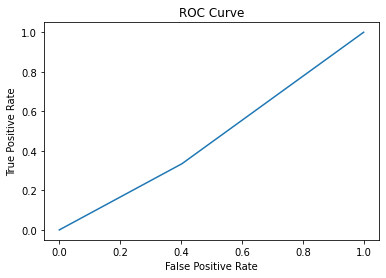

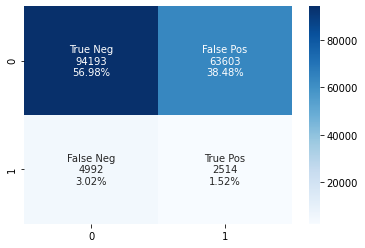

In [ ]:
predicted_list=svm.predict(X_test)
preformance_measures(y_test, predicted_list)

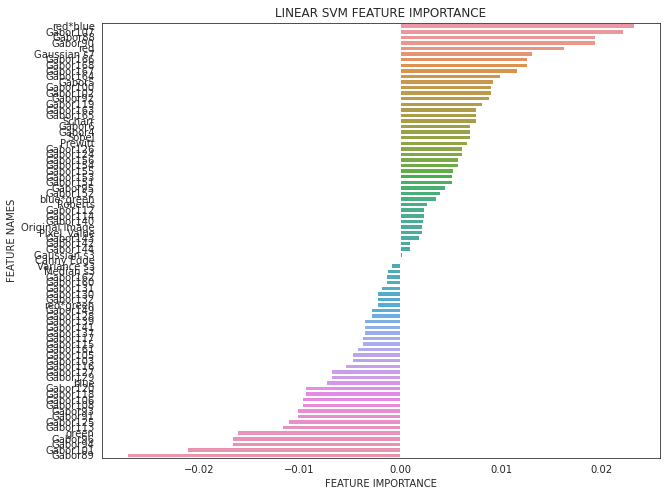

In [ ]:
plot_feature_importance(svm.coef_[0],X.columns,'LINEAR SVM ')
# f_importances(svm.coef_[0], X_train.columns)


In [ ]:
remove_less_significant_features(X,pd.DataFrame(svm.coef_[0]),pd.DataFrame(X.columns))


col droped:  []


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,-0.375585,1.463850,1.468119,1.471995,-0.399869,-0.459401,-0.212840,-0.375585,0.019985,0.020724,0.019985,0.015172,0.015389,0.015172,0.013975,0.014067,0.013975,0.013447,0.013502,0.013447,0.013172,0.013213,0.013172,0.01301,0.013034,0.01301,0.012916,0.012926,0.012916,1.086526,1.089005,1.086526,-0.881469,-0.893964,-0.881469,-0.788056,-0.786672,-0.788056,1.126817,1.134585,...,-0.947912,-0.882691,-0.877684,-0.882691,1.149711,1.156142,1.149711,-0.953977,-0.953234,-0.953977,-0.892000,-0.888546,-0.892000,1.168076,1.154944,1.168076,-0.957613,-0.957072,-0.957613,-0.897654,-0.895102,-0.897654,1.168428,1.154183,1.168428,-0.959946,-0.959528,-0.959946,-0.901340,-0.899392,-0.901340,-0.553479,-0.889785,-1.014744,-1.00728,-1.024532,-0.250691,-0.614971,0.003435,0.815789
1,0.087285,-0.227585,-0.219702,-0.228877,0.096084,0.024738,0.178214,0.087285,0.019985,0.020724,0.019985,0.015172,0.015389,0.015172,0.013975,0.014067,0.013975,0.013447,0.013502,0.013447,0.013172,0.013213,0.013172,0.01301,0.013034,0.01301,0.012916,0.012926,0.012916,-0.098031,-0.102134,-0.098031,-0.957855,-0.951605,-0.957855,-1.082181,-1.069903,-1.082181,-0.088118,-0.091668,...,-0.912399,-1.068546,-1.063781,-1.068546,-0.080400,-0.076796,-0.080400,-0.918611,-0.917847,-0.918611,-1.063349,-1.060048,-1.063349,-0.079651,-0.077005,-0.079651,-0.904699,-0.904136,-0.904699,-1.068881,-1.066438,-1.068881,-0.079155,-0.077136,-0.079155,-0.907121,-0.906686,-0.907121,-1.058228,-1.056355,-1.058228,-0.553479,-0.889785,-1.014744,-1.00728,-1.024532,-0.318388,-0.614971,0.040100,0.266701
2,0.016074,-1.390447,-1.380080,-1.398226,0.019783,-0.049745,0.118052,0.016074,0.019985,0.020724,0.019985,0.015172,0.015389,0.015172,0.013975,0.014067,0.013975,0.013447,0.013502,0.013447,0.013172,0.013213,0.013172,0.01301,0.013034,0.01301,0.012916,0.012926,0.012916,-1.246692,-1.238297,-1.246692,-0.041220,-0.048567,-0.041220,0.079613,0.063020,0.079613,-1.231586,-1.227755,...,-0.095593,0.060876,0.052802,0.060876,-1.221373,-1.220391,-1.221373,-0.105187,-0.103954,-0.105187,0.050420,0.054712,0.050420,-1.220430,-1.219683,-1.220430,-0.110988,-0.110088,-0.110988,0.058363,0.047247,0.058363,-1.219804,-1.219229,-1.219804,-0.097143,-0.096444,-0.097143,0.054253,0.056655,0.054253,-0.553479,-0.889785,-1.014744,-1.00728,-1.024532,-0.431217,-0.614971,0.040100,-0.883770
3,0.016074,-1.390447,-1.380080,-1.398226,0.019783,-0.049745,0.118052,0.016074,0.019985,0.020724,0.019985,0.015172,0.015389,0.015172,0.013975,0.014067,0.013975,0.013447,0.013502,0.013447,0.013172,0.013213,0.013172,0.01301,0.013034,0.01301,0.012916,0.012926,0.012916,-1.246692,-1.238297,-1.246692,-0.614117,-0.605761,-0.614117,-0.699818,-0.682324,-0.699818,-1.231586,-1.227755,...,-0.557266,-0.653948,-0.648641,-0.653948,-1.221373,-1.220391,-1.221373,-0.564948,-0.563981,-0.564948,-0.649255,-0.659877,-0.649255,-1.220430,-1.219683,-1.220430,-0.551939,-0.551226,-0.551939,-0.655082,-0.652375,-0.655082,-1.219804,-1.219229,-1.219804,-0.554957,-0.554407,-0.554957,-0.644614,-0.656813,-0.644614,-0.553479,-0.889785,-1.014744,-1.00728,-1.024532,-0.544046,-0.640387,0.040100,-0.007843
4,-0.874061,1.146706,1.151653,1.153081,-0.933972,-0.980781,-0.633976,-0.874061,0.019985,0.020724,0.019985,0.015172,0.015389,0.015172,0.013975,0.014067,0.013975,0.013447,0.013502,0.013447,0.013172,0.013213,0.013172,0.01301,0.013034,0.01301,0.012916,0.012926,0.012916,0.207082,0.209395,0.207082,-0.289475,-0.279130,-0.289475,-0.214512,-0.220211,-0.214512,0.215616,0.214895,...,-0.326429,-0.239350,-0.247817,-0.239350,0.222670,0.209102,0.222670,-0.335068,-0.333967,-0.335068,-0.249441,-0.245416,-0.249441,0.223368,0.208664,0.223368,-0.340282,-0.339480,-0.340282,-0.241284,-0.238313,-0.241284,0.223829,0.208388,0.223829,-0.326050,-0.325426,-0.326050,-0.245261,-0.243002,-0.245261,1.806755,-0

##Save the trained model as pickle string to disk for future use


In [ ]:
model_name = "RF_1"
pickle.dump(model, open(model_name, 'wb'))
#
##To test the model on future datasets
#loaded_model = pickle.load(open(model_name, 'rb'))

# main  בדיקה

In [ ]:
model=best_grid

NameError: ignored

In [ ]:
from matplotlib import pyplot as plt
# loaded_model = pickle.load(open(model_name, 'rb'))

test_label = cv2.imread('/content/drive/MyDrive/Colab Notebooks/segmentation/Branch/ground_truth/test/10_14.png')
test_label = cv2.cvtColor(test_label,cv2.COLOR_BGR2GRAY)
test_label = cv2.resize(test_label, (244,244), interpolation =cv2.INTER_NEAREST)
test_label = test_label.reshape(-1)

test_img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/segmentation/Branch/test/10_14.png') 
test_img1 = cv2.resize(test_img, (244,244))
test_img = remove_background(test_img1,1)

X=feature_extraction(test_img,test_img1)
X=cleanData(X)

X = pd.DataFrame(X.drop(labels = ['red*green', 'blue*green' ,'red*blue' ,'Gabor4' ,'Gabor5', 'Gabor6' ,'Gabor16',
 'Gabor17','Gabor18' ,'Gabor28' ,'Gabor29' ,'Gabor30', 'Gabor40' ,'Gabor41',
 'Gabor42', 'Gabor52', 'Gabor53' ,'Gabor54' ,'Gabor64' ,'Gabor65', 'Gabor66',
 'Gabor76' ,'Gabor77' ,'Gabor78' ,'Gabor91' ,'Gabor92' ,'Gabor93' ,'Gabor94',
 'Gabor95' ,'Gabor96', 'Gabor103' ,'Gabor104' ,'Gabor105' ,'Gabor106',
 'Gabor107', 'Gabor108', 'Gabor112' ,'Gabor114' ,'Gabor115' ,'Gabor116',
 'Gabor117' ,'Gabor118' ,'Gabor119', 'Gabor120' ,'Gabor124', 'Gabor126',
 'Gabor127' ,'Gabor128','Gabor129' ,'Gabor130' ,'Gabor131' ,'Gabor132',
 'Gabor136' ,'Gabor137', 'Gabor138' ,'Gabor139' ,'Gabor140','Gabor141',
 'Gabor142' ,'Gabor143' ,'Gabor144' ,'Gabor148' ,'Gabor149' ,'Gabor150',
 'Gabor151' ,'Gabor152' ,'Gabor153' ,'Gabor154' ,'Gabor155' ,'Gabor156',
 'Gabor160' ,'Gabor162', 'Gabor163' ,'Gabor164' ,'Gabor165' ,'Gabor166',
 'Gabor167' ,'Gabor168'], axis=1)) 
 
result = model.predict(X)
segmented = result.reshape((test_img.shape))
plt.imshow(segmented,cmap='Greys')
# plt.imsave('segmented_rock_RF_100_estim.jpg', segmented)


# https://towardsdatascience.com/evaluating-image-segmentation-models-1e9bb89a001b

how to evaluate segmentation 